<a href="https://colab.research.google.com/github/jeawonlll/KOHI2022_tutorials/blob/main/20221015/KOHI_MIMIC_TRANSFORMER_%EC%8B%A4%EC%8A%B5%EC%BD%94%EB%93%9C(%EC%8B%A4%EC%8A%B5%EC%9A%A9).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EMR Transformer 모델 개발 실습 관련 코드입니다.

## 실습 진행 순서


1.   데이터 전처리 (missing value 처리, data padding 및 normalization)
2.   레이블링 작성
3.   학습, 검증, 테스트 데이터 나누기
4.   Transformer 모델 디자인
5.   결과 분석

# ###필요한 데이터들 다운 받기
1. 아래의 코드 블럭 실행
2. 실행 후 나오는 링크를 클릭

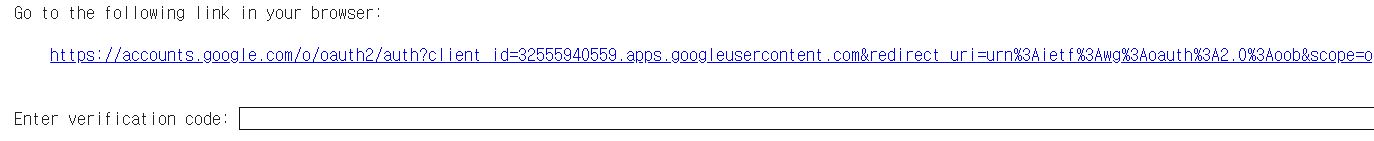
3. 로그인

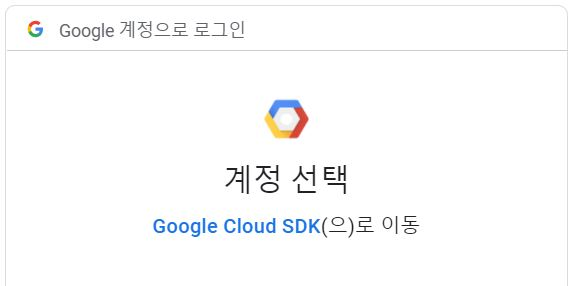

4. 허용 클릭

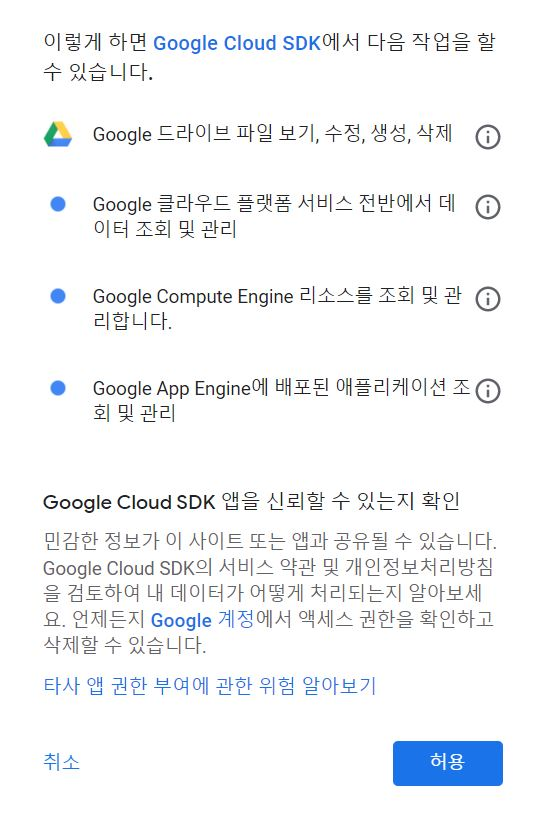
5. 코드 복사

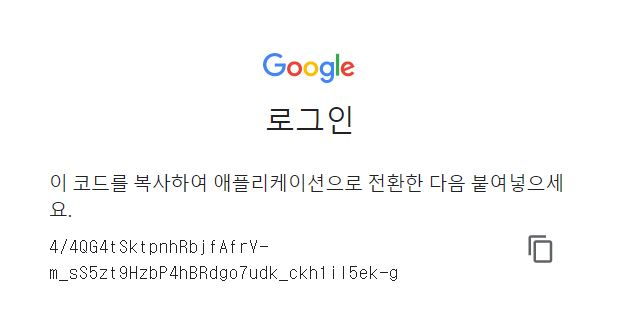
6. 코드 붙여넣기

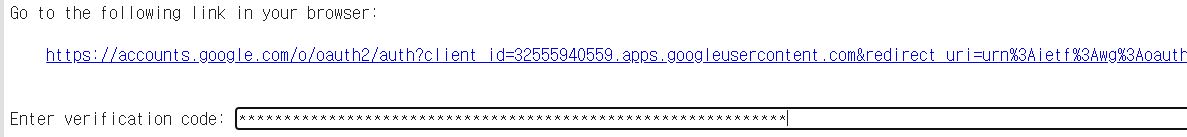

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from tqdm.autonotebook import tqdm
from datetime import timedelta, datetime

import numpy as np
import warnings
import csv
warnings.filterwarnings("ignore")

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """


In [ ]:
FILE_IDS = ["1-91Ad_3yQQ0T6ROnlxqbbgEFc6tiZAsY",
            "1-RbUxW2hF2ayWDhkMqGfKZvzEKwiLqQX",
            "1r76_XuYikaeswLAIpIbPpkx_kXgJob3a",
            "1-I25PxwI6qpDrNtDJD_jEnLl_MXh9hjH",
            "1-3YZEp8xFYplMjvFSfzb637WwA8OwW_2",
            "1-HhOwcDMse4BevovRkxOBICe5zZ3YraZ"]
FILE_NAMES = ['PATIENTS.csv', 'LABEVENTS.csv', 'CHARTEVENTS.csv',
              'D_ITEMS.csv', 'D_LABITEMS.csv', 'ADMISSIONS.csv']
for f_id, f_name in tqdm(zip(FILE_IDS, FILE_NAMES), desc="Download Files...", total=len(FILE_IDS), ncols=700):
  download_file = drive.CreateFile({'id': f_id})
  download_file.GetContentFile(f_name)

Download Files...:   0%|                                                                                      …

In [ ]:
Total_HADMIDS = set()

In [ ]:
Total_HADMIDS

set()

In [ ]:
#내원번호 리스트 만들기
Total_HADMIDS = set() #중복없애기 위해서 list 아니라 set으로 가져옴

#ADMISSION.csv 파일에서 HADM_ID값들 가져오기
reader = csv.DictReader(open('ADMISSIONS.csv', 'r', encoding='utf-8'))
for row in reader:
  Total_HADMIDS.add(row['HADM_ID'])

# Extract Features

## 학습에 사용할 입력 항목들의 값만 추출하여 따로 파일로 만들어 두기

In [ ]:
## Define some util functions
NOT_CONVERTED = 'NOT_CONVERTED'
## 문자로 기록된 날짜 값들을 파이썬의 datetime 데이터로 바꿔주는 함수 작성
def str2datetime(s):
    def _convert(_s, _dformat):
        try:
            converted_dt = datetime.strptime(_s, _dformat)
        except Exception:
            return NOT_CONVERTED

        return converted_dt

    if isinstance(s, datetime):
        return s

    dformats = [
        '%Y-%m-%d %p %I:%M:%S',
        '%Y-%m-%d %H:%M:%S.%f',
        '%Y-%m-%d %H:%M:%S',
        '%Y-%m-%d %H:%M',
        '%y-%m-%d %H:%M',
        '%Y-%m-%d',
        '%Y%m%d',
        '%Y-%m-%d +%H:%M',
        '%Y%m%d %H%M',
        '%Y%m%d%H%M%S',
        ]

    s = s.split('.')[0]
    s = s.replace('오전', 'am').replace('오후', 'pm')
    for dformat in dformats:
        dt = _convert(s, dformat)
        if dt != NOT_CONVERTED:
            return dt

    return NOT_CONVERTED

In [ ]:
## Item ID for Extract Vital Sign Features
EXTRACT_FEATURE_CODES_VS = dict({
    '220045': 'PULSE',
    '211': 'PULSE',
    '220050': 'SBP',
    '220179': 'SBP',
    '225309': 'SBP',
    '51': 'SBP',
    '455': 'SBP',
    '220051': 'DBP',
    '220180': 'DBP',
    '225310': 'DBP',
    '8368': 'DBP',
    '8441': 'DBP',
    '220210': 'RESP',
    '618': 'RESP',
    '223762': 'TEMP',
    '676': 'TEMP',
    '677': 'TEMP',
    '223761': 'TEMP_F',
    '678': 'TEMP_F',
    '679': 'TEMP_F'
})

## Item ID for Extract Lab Features
EXTRACT_FEATURE_CODES_LAB = dict({
    '50885': 'BILIRUBIN',
    '51301': 'WBC',
    '51221': 'HEMATOCRIT',
    '50813': 'LACTATE',
    '51265': 'PLATELET',
    '50912': 'CREATININE',
    '50983': 'SODIUM'
})

#항목별 정상값의 범위
FEATURE_NORMAL_RANGE = dict({
    'PULSE': (0, 300),
    'SBP': (0, 300),
    'DBP': (0, 300),
    'RESP': (0, 120),
    'TEMP': (25, 50),
    'BILIRUBIN': (0, 75),
    'WBC': (0, 100),
    'HEMATOCRIT': (0, 100),
    'LACTATE': (0, 20),
    'PLATELET': (0, 1000),
    'CREATININE': (0, 20),
    'SODIUM': (0, 500) 
})

#항목별 데이터의 평균과 표준편차
FEATURE_MEAN_STD = dict({
    'PULSE': (101.72, 32.23),
    'SBP': (121.21, 24.85),
    'DBP': (60.216, 14.94),
    'RESP': (20.12, 6.37),
    'TEMP': (37.03, 0.96),
    'BILIRUBIN': (5.31, 4.29),
    'WBC': (11.35, 7.24),
    'HEMATOCRIT': (30.7, 5.56),
    'LACTATE': (3.36, 3.03),
    'PLATELET': (226.94, 143.9),
    'CREATININE': (4.43, 2.79),
    'SODIUM': (138.77, 5.4) 
})

In [ ]:
import re

#CHARTEVENTS.csv 파일로 부터 모델 학습에 사용할 Vital Sign 값들을 가져오고
#LABEVENTS.csv 파일로 부터 모델 학습에 사용할 LAB 값들을 가져오는 함수 만들기
def extract_features():
  features_hadm_id = dict()
  chartevents = csv.DictReader(open('CHARTEVENTS.csv', 'r', encoding='utf-8'))
  labevents = csv.DictReader(open('LABEVENTS.csv', 'r', encoding='utf-8'))
  for row in tqdm(chartevents, desc='Extract_VS', total=7241351, ncols=700):
    if row['HADM_ID'] in Total_HADMIDS:
      hadm_id = row['HADM_ID']
      features_hadm_id[hadm_id] = features_hadm_id.get(hadm_id, dict()) #get 없으면 2번째로 return

      item_id = row['ITEMID']
      if item_id not in EXTRACT_FEATURE_CODES_VS:
        continue
      item_name = EXTRACT_FEATURE_CODES_VS[item_id]
      try:
        #정규식을 이용해서 기록된 값에서 숫자 형태의 값만 가져오기
        #소수점 둘째자리 까지만 값을 사용하기
        item_value = round(float(re.findall("\d+\.\d+|\d+", row['VALUENUM'])[0]), 2)
      except Exception:
        continue
      
      item_time = str2datetime(row['CHARTTIME'])
      if item_time == NOT_CONVERTED:
        continue
      #GCP total score도 시간대에 총합으로 사용함
      if item_name == 'TEMP_F':
        item_value = round((item_value - 32.0) / 1.8, 2)
        item_name = 'TEMP'

      if item_value > FEATURE_NORMAL_RANGE[item_name][1]:
        item_value = FEATURE_NORMAL_RANGE[item_name][1]
      elif item_value < FEATURE_NORMAL_RANGE[item_name][0]:
        item_value = FEATURE_NORMAL_RANGE[item_name][0]

      features_hadm_id[hadm_id][item_name] = features_hadm_id[hadm_id].get(item_name, list()) #같은 환자의 여러개 feature가 있으면 list로 반환하도록
      features_hadm_id[hadm_id][item_name].append((item_time, item_value))
      
    else:
      continue

  for row in tqdm(labevents, desc='Extract_LAB', total=615328, ncols=700):
    if row['HADM_ID'] in Total_HADMIDS:
      hadm_id = row['HADM_ID']
      features_hadm_id[hadm_id] = features_hadm_id.get(hadm_id, dict())

      item_id = row['ITEMID']
      if item_id not in EXTRACT_FEATURE_CODES_LAB:
        continue
      item_name = EXTRACT_FEATURE_CODES_LAB[item_id]
      try:
        #정규식을 이용해서 기록된 값에서 숫자 형태의 값만 가져오기
        #소수점 둘째자리 까지만 값을 사용하기
        item_value = round(float(re.findall("\d+\.\d+|\d+", row['VALUENUM'])[0]), 2)
      except Exception:
        continue
      
      item_time = str2datetime(row['CHARTTIME'])
      if item_time == NOT_CONVERTED:
        continue

      if item_value > FEATURE_NORMAL_RANGE[item_name][1]:
        item_value = FEATURE_NORMAL_RANGE[item_name][1]
      elif item_value < FEATURE_NORMAL_RANGE[item_name][0]:
        item_value = FEATURE_NORMAL_RANGE[item_name][0]
        
      features_hadm_id[hadm_id][item_name] = features_hadm_id[hadm_id].get(item_name, list())
      features_hadm_id[hadm_id][item_name].append((item_time, item_value))
      
    else:
      continue
      
  return features_hadm_id

In [ ]:
extracted_features = extract_features()

Extract_VS:   0%|                                                                                             …

Extract_LAB:   0%|                                                                                            …

In [ ]:
hadm_ids = list(extracted_features.keys())

# Missing Data Imputation
### 입실 시점으로부터 1시간 간격으로 데이터를 만들고 결측이 있는 시간대는 np.nan으로 대체하기
### 결측 값을 다음의 두 가지 방법으로 결측값 보완 하는 것을 실습

1. Carry-Forward and Normal Value
2. Python AutoImpute

In [ ]:
## 환자의 입실 퇴실 시간 정보 가져오기
Extracted_HADMIDS = list(extracted_features.keys())
admin_disc_time = dict()

admissions = csv.DictReader(open('ADMISSIONS.csv', 'r', encoding='utf-8'))
for row in admissions:
  hadm_id = row['HADM_ID']
  admin_time = str2datetime(row['ADMITTIME'])
  disc_time = str2datetime(row['DISCHTIME'])

  if (admin_time != NOT_CONVERTED) and (disc_time != NOT_CONVERTED):
    admin_disc_time[hadm_id] = dict({'ADMIN': admin_time, 'DISC': disc_time})


In [ ]:
## 입실 시점으로부터 1시간 간격으로 데이터를 읽어오는 함수 정의
def quantize_features(feature_list, admin_time, disc_time, missing_feature=False):
  total_hours = int((disc_time - admin_time).total_seconds() / (60*60))
  #입실 이후 최대 24시간 동안의 데이터만 가져오기
  if total_hours > 24:
    total_hours = 24
  
  quantized_features = list()
  if missing_feature:
    for i in range(total_hours):
      quantized_time = admin_time + timedelta(hours=i)
      quantized_value = np.nan #지금은 dic 형태라, pandas 쓰면 NAN이랑 동일, carry forward 도 가능
      quantized_features.append((quantized_time, quantized_value))
  else:
    feature_list = list(sorted(feature_list, key=lambda x: x[0]))
    for i in range(total_hours):
      quantized_time = admin_time + timedelta(hours=i)
      quantized_time_start = quantized_time - timedelta(hours=1)
      quantized_values = list(filter(lambda x: quantized_time_start < x[0] <= quantized_time, feature_list)) #filter함수 True만 필터
      if len(quantized_values) > 0:
        quantized_value = quantized_values[-1][1]
      else:
        quantized_value = np.nan 

      quantized_features.append((quantized_time, quantized_value))
  
  return quantized_features

In [ ]:
## 전체 데이터에 대해서 데이터 변환하기
quantized_features = dict()
for hadm_id in tqdm(Extracted_HADMIDS, desc='Doing Quantization'):
    feature_keys = ['PULSE', 'SBP', 'DBP', 'RESP', 'TEMP', 'BILIRUBIN', 'WBC', 'HEMATOCRIT', 'LACTATE', 'PLATELET', 'CREATININE', 'SODIUM']
    admin_time = admin_disc_time[hadm_id]['ADMIN']
    disc_time = admin_disc_time[hadm_id]['DISC']
    if (disc_time - admin_time).total_seconds() / (60*60) < 1.0:
      continue
    quantized_features[hadm_id] = dict()
    for kk in feature_keys:
      if kk in extracted_features[hadm_id]:
        feature_list = extracted_features[hadm_id][kk]
        quantized_features[hadm_id][kk] = quantize_features(feature_list, admin_time, disc_time)
      else:
        quantized_features[hadm_id][kk] = quantize_features(None, admin_time, disc_time, missing_feature=True)


Doing Quantization:   0%|          | 0/1248 [00:00<?, ?it/s]

In [ ]:
NORMAL_VALUE = dict({
    'PULSE': 80.0,
    'SBP': 120.0,
    'DBP': 80.0,
    'RESP': 14.0,
    'TEMP': 36.5,
    'BILIRUBIN': 0.6,
    'WBC': 7.0,
    'HEMATOCRIT': 45.0,
    'LACTATE': 0.7,
    'PLATELET': 300.,
    'CREATININE': 0.8,
    'SODIUM': 140.,
})

In [ ]:
def carry_forward(feature_name, feature_list):
  imputed_features = list()
  for i, (feature_t, feature_v) in enumerate(feature_list):
    if np.isnan(feature_v):
      last_observations = list(filter(lambda x: (x[0] <= feature_t) and (not np.isnan(x[1])), feature_list))
      if len(last_observations) > 0:
        imputed_features.append((feature_t, last_observations[-1][1]))
      else:
        imputed_features.append((feature_t, NORMAL_VALUE[feature_name]))
    else:
      imputed_features.append((feature_t, feature_v))

  return imputed_features

In [ ]:
Quantized_HADMIDS = list(quantized_features.keys())
carry_forwarded_features = dict()
feature_keys = ['PULSE', 'SBP', 'DBP', 'RESP', 'TEMP', 'BILIRUBIN', 'WBC', 'HEMATOCRIT', 'LACTATE', 'PLATELET', 'CREATININE', 'SODIUM']
for hadm_id in tqdm(Quantized_HADMIDS, desc='Carry-Forward'):
  carry_forwarded_features[hadm_id] = dict()

  for kk in feature_keys:
    feature_list = quantized_features[hadm_id][kk]
    carry_forwarded_features[hadm_id][kk] = carry_forward(kk, feature_list)

Carry-Forward:   0%|          | 0/1244 [00:00<?, ?it/s]

# Normalization
### 결측치를 보완한 값에서 정규화 진행하기
1. Min-Max Normalization
2. Z-Score Normalization

In [ ]:
#Min-Max Normalization
min_max_normalized = dict()
for hadm_id in tqdm(Quantized_HADMIDS, desc='Min-Max Normalization', ncols=700):
  min_max_normalized[hadm_id] = dict()
  feature_keys = ['PULSE', 'SBP', 'DBP', 'RESP', 'TEMP', 'BILIRUBIN', 'WBC', 'HEMATOCRIT', 'LACTATE', 'PLATELET', 'CREATININE', 'SODIUM']
  for kk in feature_keys:
    features = np.array(carry_forwarded_features[hadm_id][kk])

    min = FEATURE_NORMAL_RANGE[kk][0]
    max = FEATURE_NORMAL_RANGE[kk][1]

    features[:, 1] = (features[:, 1] - min) / (max - min)
    min_max_normalized[hadm_id][kk] = features

Min-Max Normalization:   0%|                                                                                  …

# 레이블 작성하기
1. 사망 레이블
2. 재실기간 레이블

In [ ]:
admissions = list(csv.DictReader(open('ADMISSIONS.csv', 'r', encoding='utf-8')))

In [ ]:
# 사망 레이블 하기
death_labels = dict()
for row in tqdm(admissions, desc='Get Death Label'):
  hadm_id = row['HADM_ID']
  death_yn = int(row['HOSPITAL_EXPIRE_FLAG'])
  if death_yn:
    event_time = str2datetime(row['DEATHTIME'])
  else:
    event_time = str2datetime(row['DISCHTIME'])

  death_labels[hadm_id] = dict({'DEATH': death_yn, 'EVENT_TIME': event_time})

Get Death Label:   0%|          | 0/1262 [00:00<?, ?it/s]

In [ ]:
# 재실 기간 레이블 하기
# 재실 기간이 24시간 이상 되는 환자들만 가져오기
# 입실 초반 12시간 데이터를 가지고 전체 입실 시간을 맞추는 모델을 위한 레이블 작성
los_labels = dict()
for row in tqdm(admissions, desc='Get Death Label'):
  hadm_id = row['HADM_ID']
  admin_time = str2datetime(row['ADMITTIME'])
  disc_time = str2datetime(row['DISCHTIME'])
  los = (disc_time - admin_time).total_seconds() / (60*60)
  if los > 24:
    los_labels[hadm_id] = int(los)
  else:
    continue

Get Death Label:   0%|          | 0/1262 [00:00<?, ?it/s]

# Data Format 변경과 학습, 검증용 데이터 나누기

정규화까지 마친 데이터를, 모델 입력에 사용하기 알맞은 형태로 변경하기
(Batch, Time, Feature)

8:2로 학습용 검증용 데이터 나누기

In [ ]:
total_death_included_hadm_ids = list(death_labels.keys())
total_los_included_hadm_ids = list(los_labels.keys())
feature_keys = ['PULSE', 'SBP', 'DBP', 'RESP', 'TEMP', 'BILIRUBIN', 'WBC', 'HEMATOCRIT', 'LACTATE', 'PLATELET', 'CREATININE', 'SODIUM']

In [ ]:
## 사망 예측용 데이터
death_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

for hadm_id in tqdm(total_death_included_hadm_ids, desc='Make Death Dataset', ncols=700):
  if hadm_id not in min_max_normalized:
    continue
  if len(min_max_normalized[hadm_id][feature_keys[0]]) >= 24:
    time_len = 24
  else:
    time_len = len(min_max_normalized[hadm_id][feature_keys[0]])
  
  try:
    data = np.array(min_max_normalized[hadm_id][feature_keys[0]])[:time_len, 1].reshape(time_len, 1)
  except:
    continue

  for kk in feature_keys[1:]:
    data = np.concatenate((data, np.array(min_max_normalized[hadm_id][kk])[:time_len, 1].reshape(time_len, 1)), axis=1)
  
  death_dataset['HADM_IDS'].append(hadm_id)
  death_dataset['LABEL'].append(death_labels[hadm_id]['DEATH'])
  death_dataset['DATA'].append(data)

Make Death Dataset:   0%|                                                                                     …

In [ ]:
## 재실기간 예측용 데이터
los_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

for hadm_id in tqdm(total_los_included_hadm_ids, desc='Make LOS Dataset', ncols=700):
  time_len = 12
  
  try:
    data = np.array(min_max_normalized[hadm_id][feature_keys[0]])[:time_len, 1].reshape(time_len, 1)
  except:
    continue

  for kk in feature_keys[1:]:
    data = np.concatenate((data, np.array(min_max_normalized[hadm_id][kk])[:time_len, 1].reshape(time_len, 1)), axis=1)
  
  los_dataset['HADM_IDS'].append(hadm_id)
  los_dataset['LABEL'].append(los_labels[hadm_id])
  los_dataset['DATA'].append(data)

Make LOS Dataset:   0%|                                                                                       …

In [ ]:
## 학습용 검증용 데이터 나누기 (8:2)
def split_train_test(dataset, train_ratio=0.8, pos_neg=True):
  #레이블이 양성, 음성인 경우, 학습 데이터, 테스트 데이터를 나눌 때 
  #양성, 음성의 비율을 각각 유지할 수 있도록 구현
  if pos_neg:
    pos_idx = np.where(np.array(dataset['LABEL']) == 1)[0]
    neg_idx = np.where(np.array(dataset['LABEL']) == 0)[0]

    # suffle 넣어줘서 index 섞어줘야함. np.random, random,suffle
    np.random.shuffle(pos_idx)
    np.random.shuffle(neg_idx)

    pos_num = len(pos_idx)
    neg_num = len(neg_idx)

    train_pos_idx = list(pos_idx[:int(pos_num * train_ratio)])
    test_pos_idx = list(pos_idx[int(pos_num * train_ratio):])

    train_neg_idx = list(neg_idx[:int(neg_num * train_ratio)])
    test_neg_idx = list(neg_idx[int(neg_num * train_ratio):])

    train_idx = train_pos_idx + train_neg_idx
    test_idx = test_pos_idx + test_neg_idx
  
  #레이블이 양성, 음성이 아닌경우 단순하게 전체 데이터에서 학습, 테스트 비율만큼 나누기
  else:
    idx = np.arange(len(dataset['LABEL']))
    np.random.shuffle(idx)
    train_idx = idx[:int(len(idx) * train_ratio)]
    test_idx = idx[int(len(idx) * train_ratio):]

  train_set = dict({
      'HADM_IDS': np.array(dataset['HADM_IDS'])[train_idx],
      'LABEL': np.array(dataset['LABEL'])[train_idx],
      'DATA': np.array(dataset['DATA'])[train_idx]
  })

  test_set = dict({
      'HADM_IDS': np.array(dataset['HADM_IDS'])[test_idx],
      'LABEL': np.array(dataset['LABEL'])[test_idx],
      'DATA': np.array(dataset['DATA'])[test_idx]
  })

  return train_set, test_set

In [ ]:
death_train, death_test = split_train_test(death_dataset)
los_train, los_test = split_train_test(los_dataset, pos_neg=False)

In [ ]:
death_train.items

<function dict.items>

In [ ]:
print(len(death_train['HADM_IDS']))
print(len(death_test['HADM_IDS']))
print(len(los_train['HADM_IDS']))
print(len(los_test['HADM_IDS']))

995
249
955
239


# 데이터 로더 만들기

모델 학습을 위해 Mini-Batch 단위로 만들어진 데이터를 가져오는 데이터 로더 만들기

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from tensorflow.keras.utils import Sequence
import numpy as np

In [ ]:
## 사망예측 모델용 데이터 로더
class Death_Dataloader(Sequence):
    def __init__(self, x_set, y_set, hadm_id_set, batch_size, shuffle=False):
        self.x, self.y, self.hadm_id = x_set, y_set, hadm_id_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

		# batch 단위로 직접 묶어줘야 함
    def __getitem__(self, idx):
		# sampler의 역할(index를 batch_size만큼 sampling해줌)
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        ## 입력 데이터들의 크기를 최대 24시간으로 통일하고 24시간 보다 짧은 데이터들의 경우 끝에 '0' padding 붙이기
        padded_batch_x = np.zeros((len(batch_x), 24, 12))
        for i in range(len(batch_x)):
          valid_length = len(batch_x[i])
          padded_batch_x[i][:valid_length, :] = batch_x[i]
        batch_y = [self.y[i] for i in indices]
        batch_hadm_id = [self.hadm_id[i] for i in indices]

        return np.array(padded_batch_x).astype('float32'), np.array(batch_y).astype('float32')

    # epoch이 끝날때마다 실행
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

death_train_loader = Death_Dataloader(death_train['DATA'], death_train['LABEL'], death_train['HADM_IDS'], 125, True)
death_test_loader = Death_Dataloader(death_test['DATA'], death_test['LABEL'], death_test['HADM_IDS'], 125, False)

In [ ]:
## 재실기간 예측 모델용 데이터 로더
class LOS_Dataloader(Sequence):
    def __init__(self, x_set, y_set, hadm_id_set, batch_size, shuffle=False):
        self.x, self.y, self.hadm_id = x_set, y_set, hadm_id_set
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

		# batch 단위로 직접 묶어줘야 함
    def __getitem__(self, idx):
				# sampler의 역할(index를 batch_size만큼 sampling해줌)
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]
        batch_hadm_id = [self.hadm_id[i] for i in indices]

        return np.array(batch_x).astype('float32'), np.array(batch_y).astype('float32').reshape(-1,1)

    # epoch이 끝날때마다 실행
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

los_train_loader = LOS_Dataloader(los_train['DATA'], los_train['LABEL'], los_train['HADM_IDS'], 125, True)
los_test_loader = LOS_Dataloader(los_test['DATA'], los_test['LABEL'], los_test['HADM_IDS'], 125, True)

# 모델 만들기
LSTM기반 예측 모델 만들기
1. 사망예측 모델
2. 재실기간 예측 모델


In [ ]:
## 사망예측 모델
death_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(24,12)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
death_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25)                3800      
                                                                 
 dense (Dense)               (None, 125)               3250      
                                                                 
 dense_1 (Dense)             (None, 1)                 126       
                                                                 
Total params: 7,176
Trainable params: 7,176
Non-trainable params: 0
_________________________________________________________________


Transformer기반 예측 모델 만들기
1. 사망예측 모델
2. 재실기간 예측 모델

In [ ]:
# Token Embedding 및 Poisitional Encoding Block 구현
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.maxlen = maxlen
        self.embed_dim = embed_dim
        self.token_emb = layers.Dense(embed_dim, activation='relu')

    def get_angles(self):
      pos = np.arange(self.maxlen)[:, np.newaxis]
      i = np.arange(self.embed_dim)[np.newaxis, :]
      angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(self.embed_dim))
      return pos * angle_rates

    def pos_enc(self):
      angle_rads = self.get_angles()
      
      # 짝수 인덱스에 sin 적용; 2i
      angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
      # 홀수 인덱스에 cos 적용; 2i+1
      angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
      pos_encoding = angle_rads[np.newaxis, ...]

      return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x):
        positions = self.pos_enc()
        x = self.token_emb(x) * tf.math.sqrt(tf.cast(self.embed_dim, tf.float32))
        return x + positions

In [ ]:
# Transformer Block 구현
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(embed_dim),] #tras안에 feed forward
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
## 사망예측 모델
death_trans = keras.Sequential([
    TokenAndPositionEmbedding(maxlen=24, embed_dim=32),
    TransformerBlock(embed_dim=32, num_heads=4, ff_dim=128, rate=0.05),
    TransformerBlock(embed_dim=32, num_heads=4, ff_dim=128, rate=0.05),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid')
])

#모델 학습하기

In [ ]:
## 사망예측 모델 학습
death_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 50
history = death_lstm.fit(death_train_loader, validation_data=death_test_loader, epochs=num_epochs, verbose=2)

Epoch 1/50
8/8 - 7s - loss: 0.6304 - accuracy: 0.8905 - val_loss: 0.5585 - val_accuracy: 0.8916 - 7s/epoch - 864ms/step
Epoch 2/50
8/8 - 0s - loss: 0.4968 - accuracy: 0.8915 - val_loss: 0.3970 - val_accuracy: 0.8916 - 85ms/epoch - 11ms/step
Epoch 3/50
8/8 - 0s - loss: 0.3536 - accuracy: 0.8915 - val_loss: 0.3240 - val_accuracy: 0.8916 - 90ms/epoch - 11ms/step
Epoch 4/50
8/8 - 0s - loss: 0.3381 - accuracy: 0.8915 - val_loss: 0.3346 - val_accuracy: 0.8916 - 87ms/epoch - 11ms/step
Epoch 5/50
8/8 - 0s - loss: 0.3332 - accuracy: 0.8915 - val_loss: 0.3222 - val_accuracy: 0.8916 - 84ms/epoch - 10ms/step
Epoch 6/50
8/8 - 0s - loss: 0.3296 - accuracy: 0.8915 - val_loss: 0.3248 - val_accuracy: 0.8916 - 91ms/epoch - 11ms/step
Epoch 7/50
8/8 - 0s - loss: 0.3288 - accuracy: 0.8915 - val_loss: 0.3204 - val_accuracy: 0.8916 - 84ms/epoch - 10ms/step
Epoch 8/50
8/8 - 0s - loss: 0.3257 - accuracy: 0.8915 - val_loss: 0.3191 - val_accuracy: 0.8916 - 83ms/epoch - 10ms/step
Epoch 9/50
8/8 - 0s - loss: 0.324

In [ ]:
## 사망예측 모델 학습
death_trans.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 50
history = death_trans.fit(death_train_loader, validation_data=death_test_loader, epochs=num_epochs, verbose=2)

Epoch 1/50
8/8 - 3s - loss: 0.3938 - accuracy: 0.8905 - val_loss: 0.3261 - val_accuracy: 0.8916 - 3s/epoch - 353ms/step
Epoch 2/50
8/8 - 0s - loss: 0.3455 - accuracy: 0.8915 - val_loss: 0.3230 - val_accuracy: 0.8916 - 147ms/epoch - 18ms/step
Epoch 3/50
8/8 - 0s - loss: 0.3383 - accuracy: 0.8915 - val_loss: 0.3279 - val_accuracy: 0.8916 - 139ms/epoch - 17ms/step
Epoch 4/50
8/8 - 0s - loss: 0.3270 - accuracy: 0.8945 - val_loss: 0.3228 - val_accuracy: 0.8876 - 138ms/epoch - 17ms/step
Epoch 5/50
8/8 - 0s - loss: 0.3219 - accuracy: 0.8935 - val_loss: 0.3159 - val_accuracy: 0.8916 - 140ms/epoch - 17ms/step
Epoch 6/50
8/8 - 0s - loss: 0.3195 - accuracy: 0.8945 - val_loss: 0.3118 - val_accuracy: 0.8916 - 148ms/epoch - 19ms/step
Epoch 7/50
8/8 - 0s - loss: 0.3186 - accuracy: 0.8995 - val_loss: 0.3076 - val_accuracy: 0.8916 - 136ms/epoch - 17ms/step
Epoch 8/50
8/8 - 0s - loss: 0.3152 - accuracy: 0.8955 - val_loss: 0.3076 - val_accuracy: 0.8876 - 141ms/epoch - 18ms/step
Epoch 9/50
8/8 - 0s - loss

# 재실기간 예측 모델 구성 및 학습 코드 작성해보기

In [ ]:
## 재실기간 예측 모델
## Transformer 모델로 구성 (사망예측 모델과 거의 유사하게 구성, 마지막 레이어의 활성함수만 Regression에 맞게 구성)
los_trans = keras.Sequential([
    TokenAndPositionEmbedding(maxlen=24, embed_dim=32),
    TransformerBlock(embed_dim=32, num_heads=4, ff_dim=128, rate=0.05),
    TransformerBlock(embed_dim=32, num_heads=4, ff_dim=128, rate=0.05),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid')
])

los_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(24,12)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
## 사망예측 모델 학습
los_lstm.compile(loss='MeanSquaredError', optimizer='rmsprop', metrics=['MeanAbsoluteError'])
num_epochs = 50
history = los_lstm.fit(los_train_loader, validation_data = los_test_loader, epochs = num_epochs, verbose = 2)

Epoch 1/50
8/8 - 2s - loss: 146252.6094 - mean_absolute_error: 257.9408 - val_loss: 128685.7266 - val_mean_absolute_error: 246.4185 - 2s/epoch - 288ms/step
Epoch 2/50
8/8 - 0s - loss: 146131.8750 - mean_absolute_error: 257.7121 - val_loss: 128571.8750 - val_mean_absolute_error: 246.1878 - 81ms/epoch - 10ms/step
Epoch 3/50
8/8 - 0s - loss: 146060.0469 - mean_absolute_error: 257.5694 - val_loss: 128548.7734 - val_mean_absolute_error: 246.1408 - 78ms/epoch - 10ms/step
Epoch 4/50
8/8 - 0s - loss: 146046.4219 - mean_absolute_error: 257.5424 - val_loss: 128543.4453 - val_mean_absolute_error: 246.1299 - 75ms/epoch - 9ms/step
Epoch 5/50
8/8 - 0s - loss: 146042.6562 - mean_absolute_error: 257.5352 - val_loss: 128541.4219 - val_mean_absolute_error: 246.1257 - 78ms/epoch - 10ms/step
Epoch 6/50
8/8 - 0s - loss: 146041.1406 - mean_absolute_error: 257.5322 - val_loss: 128540.4766 - val_mean_absolute_error: 246.1239 - 78ms/epoch - 10ms/step
Epoch 7/50
8/8 - 0s - loss: 146040.4219 - mean_absolute_erro

In [ ]:
## 재실기간 예측 모델 학습
## loss: tf.losses.MeanSquaredError()
## optimizer: rmsprop
## metrics: tf.metrics.MeanAbsoluteError()
los_trans.compile(loss='MeanSquaredError', optimizer='rmsprop', metrics=['MeanAbsoluteError'])
num_epochs = 50
history = los_trans.fit(los_train_loader, validation_data=los_test_loader, epochs=num_epochs, verbose=2)

InvalidArgumentError: ignored

# 모델 검증 및 결과 정리

4/4 [==============================] - 0s 5ms/step


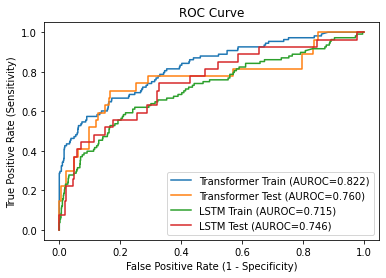

In [ ]:
# Trainset, Testset에 대한 ROC 커브 그리고 Confusion Matrix 구해보기
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score, confusion_matrix

%matplotlib inline
lstm_train_predicts, lstm_test_predicts = list(), list()
lstm_train_labels, lstm_test_labels = list(), list()
trans_train_predicts, trans_test_predicts = list(), list()
trans_train_labels, trans_test_labels = list(), list()

for tr_x, tr_y in death_train_loader:
  batch_predict = death_lstm.predict(tr_x)
  lstm_train_predicts.append(batch_predict)
  lstm_train_labels.append(tr_y)

  batch_predict = death_trans.predict(tr_x)
  trans_train_predicts.append(batch_predict)
  trans_train_labels.append(tr_y)

for test_x, test_y in death_test_loader:
  batch_predict = death_lstm.predict(test_x)
  lstm_test_predicts.append(batch_predict)
  lstm_test_labels.append(test_y)

  batch_predict = death_trans.predict(test_x)
  trans_test_predicts.append(batch_predict)
  trans_test_labels.append(test_y)

lstm_train_predicts = np.concatenate(lstm_train_predicts).reshape(-1, 1)
lstm_train_labels = np.concatenate(lstm_train_labels).astype('int')
lstm_test_predicts = np.concatenate(lstm_test_predicts).reshape(-1, 1)
lstm_test_labels = np.concatenate(lstm_test_labels).astype('int')

trans_train_predicts = np.concatenate(trans_train_predicts).reshape(-1, 1)
trans_train_labels = np.concatenate(trans_train_labels).astype('int')
trans_test_predicts = np.concatenate(trans_test_predicts).reshape(-1, 1)
trans_test_labels = np.concatenate(trans_test_labels).astype('int')


trans_train_roc_x, trans_train_roc_y, _ = roc_curve(trans_train_labels, trans_train_predicts)
trans_train_auroc = roc_auc_score(trans_train_labels, trans_train_predicts)
trans_test_roc_x, trans_test_roc_y, _ = roc_curve(trans_test_labels, trans_test_predicts)
trans_test_auroc = roc_auc_score(trans_test_labels, trans_test_predicts)
# trans_train_roc_x, trans_train_roc_y, _ = roc_curve(trans_train_labels, trans_train_predicts)
# trans_train_auroc = roc_auc_score(trans_train_labels, trans_train_predicts)
# trans_test_roc_x, trans_test_roc_y, _ = roc_curve(trans_test_labels, trans_test_predicts)
# trans_test_auroc = roc_auc_score(trans_test_labels, trans_test_predicts)

lstm_train_roc_x, lstm_train_roc_y, _ = roc_curve(lstm_train_labels, lstm_train_predicts)
lstm_train_auroc = roc_auc_score(lstm_train_labels, lstm_train_predicts)
lstm_test_roc_x, lstm_test_roc_y, _ = roc_curve(lstm_test_labels, lstm_test_predicts)
lstm_test_auroc = roc_auc_score(lstm_test_labels, lstm_test_predicts)
# lstm_train_roc_x, lstm_train_roc_y, _ = roc_curve(lstm_train_labels, lstm_train_predicts)
# lstm_train_auroc = roc_auc_score(lstm_train_labels, lstm_train_predicts)
# lstm_test_roc_x, lstm_test_roc_y, _ = roc_curve(lstm_test_labels, lstm_test_predicts)
# lstm_test_auroc = roc_auc_score(lstm_test_labels, lstm_test_predicts)

plt.figure()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')


plt.plot(trans_train_roc_x, trans_train_roc_y, linewidth=1.5, label='{} (AUROC={:.3f})'.format('Transformer Train', trans_train_auroc))
plt.plot(trans_test_roc_x, trans_test_roc_y, linewidth=1.5, label='{} (AUROC={:.3f})'.format('Transformer Test', trans_test_auroc))
plt.plot(lstm_train_roc_x, lstm_train_roc_y, linewidth=1.5, label='{} (AUROC={:.3f})'.format('LSTM Train', lstm_train_auroc))
plt.plot(lstm_test_roc_x, lstm_test_roc_y, linewidth=1.5, label='{} (AUROC={:.3f})'.format('LSTM Test', lstm_test_auroc))
# plt.plot(trans_train_roc_x, trans_train_roc_y, linewidth=1.5, label='{} (AUROC={:.3f})'.format('Transformer Train', trans_train_auroc))
# plt.plot(trans_test_roc_x, trans_test_roc_y, linewidth=1.5, label='{} (AUROC={:.3f})'.format('Transformer Test', trans_test_auroc))
# plt.plot(lstm_train_roc_x, lstm_train_roc_y, linewidth=1.5, label='{} (AUROC={:.3f})'.format('LSTM Train', lstm_train_auroc))
# plt.plot(lstm_test_roc_x, lstm_test_roc_y, linewidth=1.5, label='{} (AUROC={:.3f})'.format('LSTM Test', lstm_test_auroc))

plt.legend(fancybox=True)

plt.show()

In [ ]:
print(trans_train_predicts[0])
print(trans_train_labels[0])
print(death_train['HADM_IDS'][0])
print(death_train['DATA'][0])

[0.37431136]
1
150567
[[0.26666666666666666 0.4 0.26666666666666666 0.11666666666666667 0.46
  0.008 0.07 0.45 0.034999999999999996 0.3 0.04 0.28]
 [0.26666666666666666 0.4 0.26666666666666666 0.11666666666666667 0.46
  0.008 0.07 0.45 0.034999999999999996 0.3 0.04 0.28]
 [0.14 0.5033333333333333 0.26666666666666666 0.16666666666666666 0.46
  0.008 0.07 0.45 0.034999999999999996 0.3 0.04 0.28]
 [0.14666666666666667 0.49333333333333335 0.2633333333333333 0.15 0.46
  0.008 0.07 0.45 0.034999999999999996 0.3 0.04 0.28]
 [0.15 0.52 0.2633333333333333 0.15 0.46 0.008 0.07 0.45
  0.034999999999999996 0.3 0.04 0.28]
 [0.16333333333333333 0.52 0.2633333333333333 0.15833333333333333 0.46
  0.008 0.07 0.45 0.034999999999999996 0.3 0.04 0.28]
 [0.20333333333333334 0.52 0.2633333333333333 0.225 0.46 0.008 0.07 0.45
  0.034999999999999996 0.3 0.04 0.28]
 [0.3566666666666667 0.52 0.2633333333333333 0.25 0.46 0.008 0.07 0.45
  0.034999999999999996 0.3 0.04 0.28]
 [0.35 0.52 0.2633333333333333 0.3 0.4

In [ ]:
cut_off_range = np.arange(0.1, 0.2, 0.01)
for cut_off in cut_off_range:
  cnf_table = confusion_matrix(lstm_test_labels, lstm_test_predicts > cut_off)
  tn, fp, fn, tp = cnf_table.ravel()

  #민감도 특이도 계산하기
  sensitivity = tp / (tp + fn)
  specificity = tn / (tn + fp)
  f1 = 2*tp / (2*tp + fp + fn)
  npv = tn / (tn + fn)
  ppv = tp / (tp + fp)

#   print('###Cut-Off: {:.01f}'.format(cut_off))
  print('###Cut-Off: {:.001f}'.format(cut_off))
  print('Test Sensitivity: {:.3f}'.format(sensitivity))
  print('Test Spesificity: {:.3f}'.format(specificity))
  print('Test F1: {:.3f}'.format(f1))
  print('Test NPV: {:.3f}'.format(npv))
  print('Test PPV: {:.3f}'.format(ppv))

In [ ]:
cut_off_range = np.arange(0.1, 0.9, 0.1)
for cut_off in cut_off_range:
  cnf_table = confusion_matrix(trans_test_labels, trans_test_predicts > cut_off)
  tn, fp, fn, tp = cnf_table.ravel()

  #민감도 특이도 계산하기
  sensitivity = tp / (tp + fn)
  specificity = tn / (tn + fp)
  f1 = 2*tp / (2*tp + fp + fn)
  npv = tn / (tn + fn)
  ppv = tp / (tp + fp)

  print('###Cut-Off: {:.1f}'.format(cut_off))
  print('Test Sensitivity: {:.3f}'.format(sensitivity))
  print('Test Spesificity: {:.3f}'.format(specificity))
  print('Test F1: {:.3f}'.format(f1))
  print('Test NPV: {:.3f}'.format(npv))
  print('Test PPV: {:.3f}'.format(ppv))

###Cut-Off: 0.1
Test Sensitivity: 0.630
Test Spesificity: 0.847
Test F1: 0.436
Test NPV: 0.949
Test PPV: 0.333
###Cut-Off: 0.2
Test Sensitivity: 0.444
Test Spesificity: 0.901
Test F1: 0.393
Test NPV: 0.930
Test PPV: 0.353
###Cut-Off: 0.3
Test Sensitivity: 0.370
Test Spesificity: 0.937
Test F1: 0.392
Test NPV: 0.924
Test PPV: 0.417
###Cut-Off: 0.4
Test Sensitivity: 0.296
Test Spesificity: 0.955
Test F1: 0.356
Test NPV: 0.918
Test PPV: 0.444
###Cut-Off: 0.5
Test Sensitivity: 0.296
Test Spesificity: 0.968
Test F1: 0.381
Test NPV: 0.919
Test PPV: 0.533
###Cut-Off: 0.6
Test Sensitivity: 0.296
Test Spesificity: 0.973
Test F1: 0.390
Test NPV: 0.919
Test PPV: 0.571
###Cut-Off: 0.7
Test Sensitivity: 0.222
Test Spesificity: 0.977
Test F1: 0.316
Test NPV: 0.912
Test PPV: 0.545
###Cut-Off: 0.8
Test Sensitivity: 0.222
Test Spesificity: 0.986
Test F1: 0.333
Test NPV: 0.912
Test PPV: 0.667


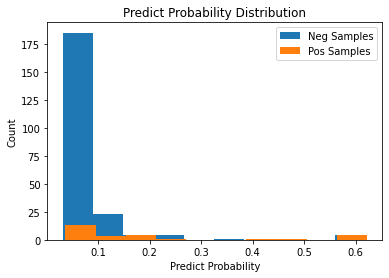

In [ ]:
#양성 음성 샘플에 대한 예측 확률값의 히스토그램 그려보기
#양성 음성 샘플에 해당하는 인덱스 값 가져오기
pos_idx = np.where(lstm_test_labels==1)[0]
neg_idx = np.where(lstm_test_labels==0)[0]

#모델이 예측한 결과 값을 양성, 음성에 따라 나누기
pos_prob = lstm_test_predicts[pos_idx]
neg_prob = lstm_test_predicts[neg_idx]

#히스토그램 그리기
plt.figure()
plt.xlabel('Predict Probability')
plt.ylabel('Count')
plt.title('Predict Probability Distribution')


plt.hist(neg_prob, bins=10, label='Neg Samples')
plt.hist(pos_prob, bins=10, label='Pos Samples')


plt.legend(fancybox=True)

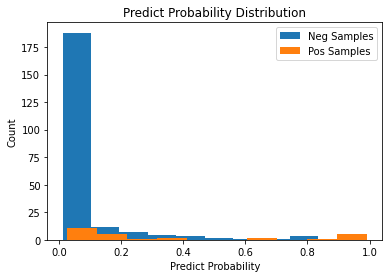

In [ ]:
pos_idx = np.where(trans_test_labels==1)[0]
neg_idx = np.where(trans_test_labels==0)[0]

pos_prob = trans_test_predicts[pos_idx]
neg_prob = trans_test_predicts[neg_idx]

plt.figure()
plt.xlabel('Predict Probability')
plt.ylabel('Count')
plt.title('Predict Probability Distribution')


plt.hist(neg_prob, bins=10, label='Neg Samples')
plt.hist(pos_prob, bins=10, label='Pos Samples')

plt.legend(fancybox=True)


# 환자별 Trajectory 그리기

In [ ]:
# Draw Trajectory
## Make Patient's trajectory dataset
## Patient's HADM_ID: 103194
## 입실 시점으로부터 1시간 간격으로 데이터를 읽어오는 함수 정의
def quantize_features_v2(feature_list, admin_time, disc_time, missing_feature=False):
  total_hours = int((disc_time - admin_time).total_seconds() / (60*60))
  #입실 이후 최대 48시간 동안의 데이터만 가져오기 (총 24시간 동안의 Trajectory를 그리기 위해서 기존의 24시간 데이터만 가져오는 것에서 48시간으로 변경)
  if total_hours > 48:
    total_hours = 48
  
  quantized_features = list()
  if missing_feature:
    for i in range(total_hours):
      quantized_time = admin_time + timedelta(hours=i)
      quantized_value = np.nan
      quantized_features.append((quantized_time, quantized_value))
  else:
    feature_list = list(sorted(feature_list, key=lambda x: x[0]))
    for i in range(total_hours):
      quantized_time = admin_time + timedelta(hours=i)
      quantized_time_start = quantized_time - timedelta(hours=1)
      quantized_values = list(filter(lambda x: quantized_time_start < x[0] <= quantized_time, feature_list))
      if len(quantized_values) > 0:
        quantized_value = quantized_values[-1][1]
      else:
        quantized_value = np.nan

      quantized_features.append((quantized_time, quantized_value))
  
  return quantized_features

In [ ]:
## Trajectory를 그릴 환자의 데이터 변환하기
quantized_features_v2_dic = dict()
Trajectory_HADM_IDS = ['103194']
for hadm_id in tqdm(Trajectory_HADM_IDS, desc='Doing Quantization'):
    feature_keys = ['PULSE', 'SBP', 'DBP', 'RESP', 'TEMP', 'BILIRUBIN', 'WBC', 'HEMATOCRIT', 'LACTATE', 'PLATELET', 'CREATININE', 'SODIUM']
    admin_time = admin_disc_time[hadm_id]['ADMIN']
    disc_time = admin_disc_time[hadm_id]['DISC']
    if (disc_time - admin_time).total_seconds() / (60*60) < 1.0:
      continue
    quantized_features_v2_dic[hadm_id] = dict()
    for kk in feature_keys:
      if kk in extracted_features[hadm_id]:
        feature_list = extracted_features[hadm_id][kk]
        quantized_features_v2_dic[hadm_id][kk] = quantize_features_v2(feature_list, admin_time, disc_time)
      else:
        quantized_features_v2_dic[hadm_id][kk] = quantize_features_v2(None, admin_time, disc_time, missing_feature=True)


Doing Quantization:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#결측값 보정하기
carry_forwarded_trajectory = dict()
feature_keys = ['PULSE', 'SBP', 'DBP', 'RESP', 'TEMP', 'BILIRUBIN', 'WBC', 'HEMATOCRIT', 'LACTATE', 'PLATELET', 'CREATININE', 'SODIUM']
for hadm_id in tqdm(Trajectory_HADM_IDS, desc='Carry-Forward'):
  carry_forwarded_trajectory[hadm_id] = dict()

  for kk in feature_keys:
    feature_list = quantized_features_v2_dic[hadm_id][kk]
    carry_forwarded_trajectory[hadm_id][kk] = carry_forward(kk, feature_list)

Carry-Forward:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#정규화 진행하기
normalized_trajectory = dict()
for hadm_id in tqdm(Trajectory_HADM_IDS, desc='Min-Max Normalization', ncols=700):
  normalized_trajectory[hadm_id] = dict()
  feature_keys = ['PULSE', 'SBP', 'DBP', 'RESP', 'TEMP', 'BILIRUBIN', 'WBC', 'HEMATOCRIT', 'LACTATE', 'PLATELET', 'CREATININE', 'SODIUM']
  for kk in feature_keys:
    features = np.array(carry_forwarded_trajectory[hadm_id][kk])

    min = FEATURE_NORMAL_RANGE[kk][0]
    max = FEATURE_NORMAL_RANGE[kk][1]

    features[:, 1] = (features[:, 1] - min) / (max - min)
    normalized_trajectory[hadm_id][kk] = features

Min-Max Normalization:   0%|                                                                                  …

In [ ]:
trajectory_inputs = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})
for hadm_id in tqdm(Trajectory_HADM_IDS, desc='Make Death Dataset', ncols=700):
  for i, time_len in enumerate(range(24,48,1)):
    data = np.array(normalized_trajectory[hadm_id][feature_keys[0]])[i:time_len, 1].reshape(24, 1)
    for kk in feature_keys[1:]:
      data = np.concatenate((data, np.array(normalized_trajectory[hadm_id][kk])[i:time_len, 1].reshape(24, 1)), axis=1)
    
    trajectory_inputs['HADM_IDS'].append(hadm_id)
    trajectory_inputs['LABEL'].append(1)
    trajectory_inputs['DATA'].append(data)

Make Death Dataset:   0%|                                                                                     …

In [ ]:
death_tajectory_loader = Death_Dataloader(trajectory_inputs['DATA'], trajectory_inputs['LABEL'], trajectory_inputs['HADM_IDS'], 24, False)
for test_x, test_y in death_tajectory_loader:
  trajectory_preds = death_trans.predict(test_x)


1/1 [==============================] - 0s 20ms/step


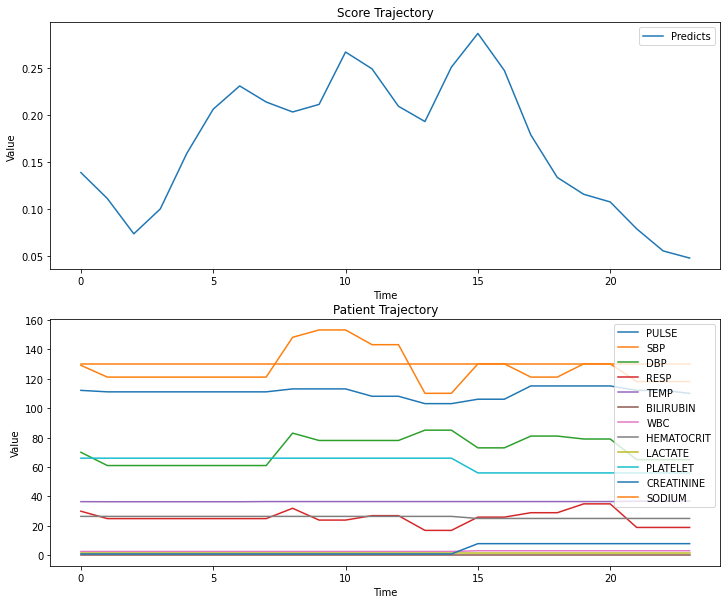

In [ ]:
'''
Features: 'PULSE', 'SBP', 'DBP', 'RESP', 'TEMP', 'BILIRUBIN', 'WBC', 'HEMATOCRIT', 'LACTATE', 'PLATELET', 'CREATININE', 'SODIUM'
'''
feature_keys = ['PULSE', 'SBP', 'DBP', 'RESP', 'TEMP', 'BILIRUBIN', 'WBC', 'HEMATOCRIT', 'LACTATE', 'PLATELET', 'CREATININE', 'SODIUM']

fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(2, 1, 1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Score Trajectory')


ax2 = fig.add_subplot(2, 1, 2)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Patient Trajectory')


ax1.plot(np.arange(24), trajectory_preds, label='Predicts')
ax1.legend(fancybox=True)

for kk in feature_keys:
  #Feature값들에 대한 Trajectry를 그릴때는 정규하 하기 이전의 값을 가지고 그려야 값을 알아볼 수 있음
  ax2.plot(np.arange(24), np.array(carry_forwarded_trajectory['103194'][kk])[-24:, 1], label=kk)
ax2.legend(fancybox=True)


# Feature Importance

In [ ]:
##데이터의 가장 마지막 Time Step의 값만을 가지고 와서 데이터셋 만들기
death_train_static = list()
death_test_static = list()
death_train_label = death_train['LABEL']
death_test_label = death_test['LABEL']

for data in death_train['DATA']:
  death_train_static.append(data[-1, :])
death_train_static = np.array(death_train_static)

for data in death_test['DATA']:
  death_test_static.append(data[-1, :])
death_test_static = np.array(death_test_static)

In [ ]:
## Random Forest, XGBoost, LR 모델 학습하기
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Random Forest 모델 학습하기
RF = RandomForestClassifier(max_depth=2, random_state=0)
RF.fit(death_train_static, death_train_label)

# XGBoost 모델 학습하기
XGB = XGBClassifier(importance='gain')
XGB.fit(death_train_static, death_train_label)

# Logistic Regression 모델 학습하기
LR = LogisticRegression()
LR.fit(death_train_static, death_train_label)


LogisticRegression()

[0.02636295 0.18015032 0.11455739 0.03158507 0.11060692 0.13176413
 0.05168284 0.03532585 0.13588382 0.06303282 0.02651188 0.09253601]
[0.06422497 0.1158909  0.077645   0.07606982 0.07991583 0.07761204
 0.07162785 0.06902997 0.12190492 0.07038385 0.09056994 0.08512488]


<BarContainer object of 12 artists>

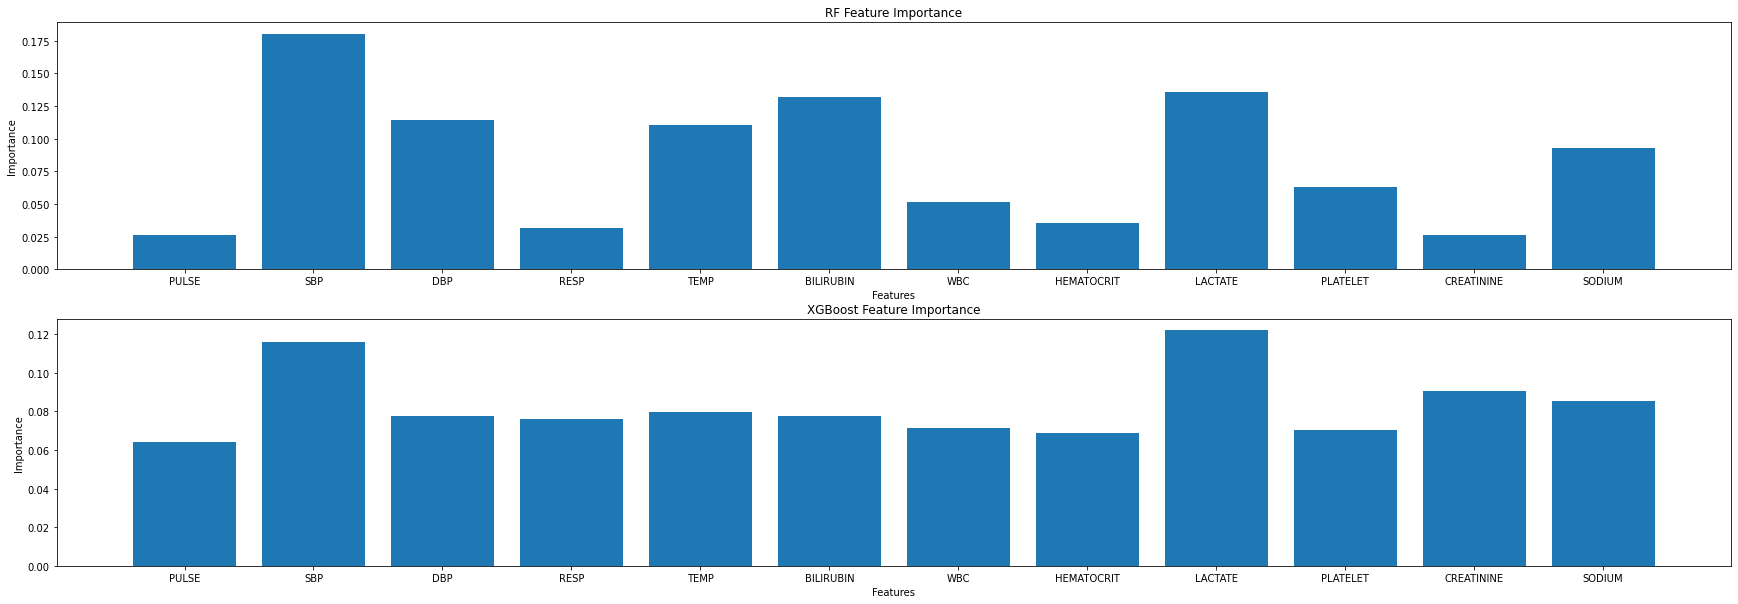

In [ ]:
RF_importance = RF.feature_importances_
XGB_importance = XGB.feature_importances_

print(RF_importance)
print(XGB_importance)

'''
Features: 'PULSE', 'SBP', 'DBP', 'RESP', 'TEMP', 'BILIRUBIN', 'WBC', 'HEMATOCRIT', 'LACTATE', 'PLATELET', 'CREATININE', 'SODIUM'
'''
feature_keys = ['PULSE', 'SBP', 'DBP', 'RESP', 'TEMP', 'BILIRUBIN', 'WBC', 'HEMATOCRIT', 'LACTATE', 'PLATELET', 'CREATININE', 'SODIUM']

fig = plt.figure(figsize=(30, 10))
ax1 = fig.add_subplot(2, 1, 1)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('RF Feature Importance')


ax2 = fig.add_subplot(2, 1, 2)

plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('XGBoost Feature Importance')


ax1.bar(feature_keys, RF_importance)

ax2.bar(feature_keys, XGB_importance)

In [ ]:
#SHAP 패키지 설치하기
!pip install shap
import shap
import pandas as pd

#SHAP 패키지를 사용하기 위해 Data Frame 형태로 데이터를 변경하기. 데이터 타입은 double로 지정
df_train_x = pd.DataFrame(death_train_static, columns=feature_keys).astype('double')
shap_values = shap.LinearExplainer(LR, masker=df_train_x).shap_values(df_train_x)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 8.2 MB/s 


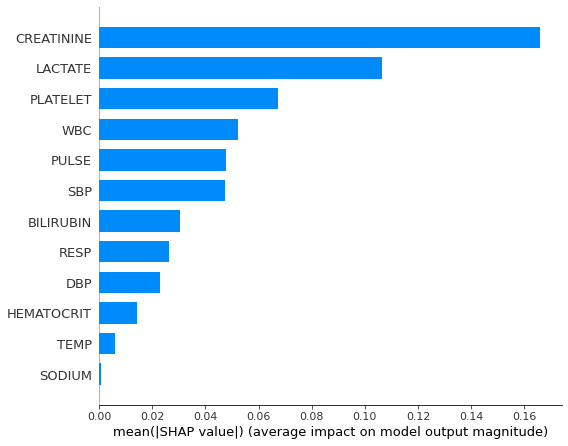

In [ ]:
#SHAP Feature Importance
shap.summary_plot(shap_values, df_train_x, plot_type="bar")

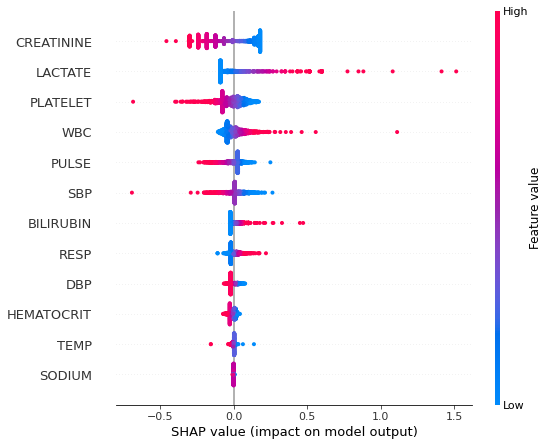

In [ ]:
#SHAP Summary plot
shap.summary_plot(shap_values, df_train_x)